# Understanding Agent Based Model with Python

*   **Phenomenon to be modeled.**  What happens when a given information about a product is spread among a population of individual.

*   **Environment.** Agents can move around, one cell at the time, in one of the neighbor cells (according to the [Moore](https://en.wikipedia.org/wiki/Moore_neighborhood) definition of neighborhood).
* **Agents**. In this scenario, agents are simple human being which are endowed with only two rules: 1) they can move in one of the neighbor cell and 2) they can influence with their knowledge that of their neighbors, which get influenced with probability p. The agents’ ability to influence others depends on their “knowledge” feature: if it is equal to 1, it means the agent is aware of the product (in that case, the agent can influence others), otherwise it is 0.
* **Model**. Step 1 is that is a grid space with a population of agents. Each agent has an internal state of knowledge which can be either 1 (if aware of the product) or 0 (if not aware). Agents with product knowledge can influence those with which they have more contacts (probably their neighbors) about the existence of that product, and this influence will have an impact with a given probability p.


The graphical representation of the  model is:
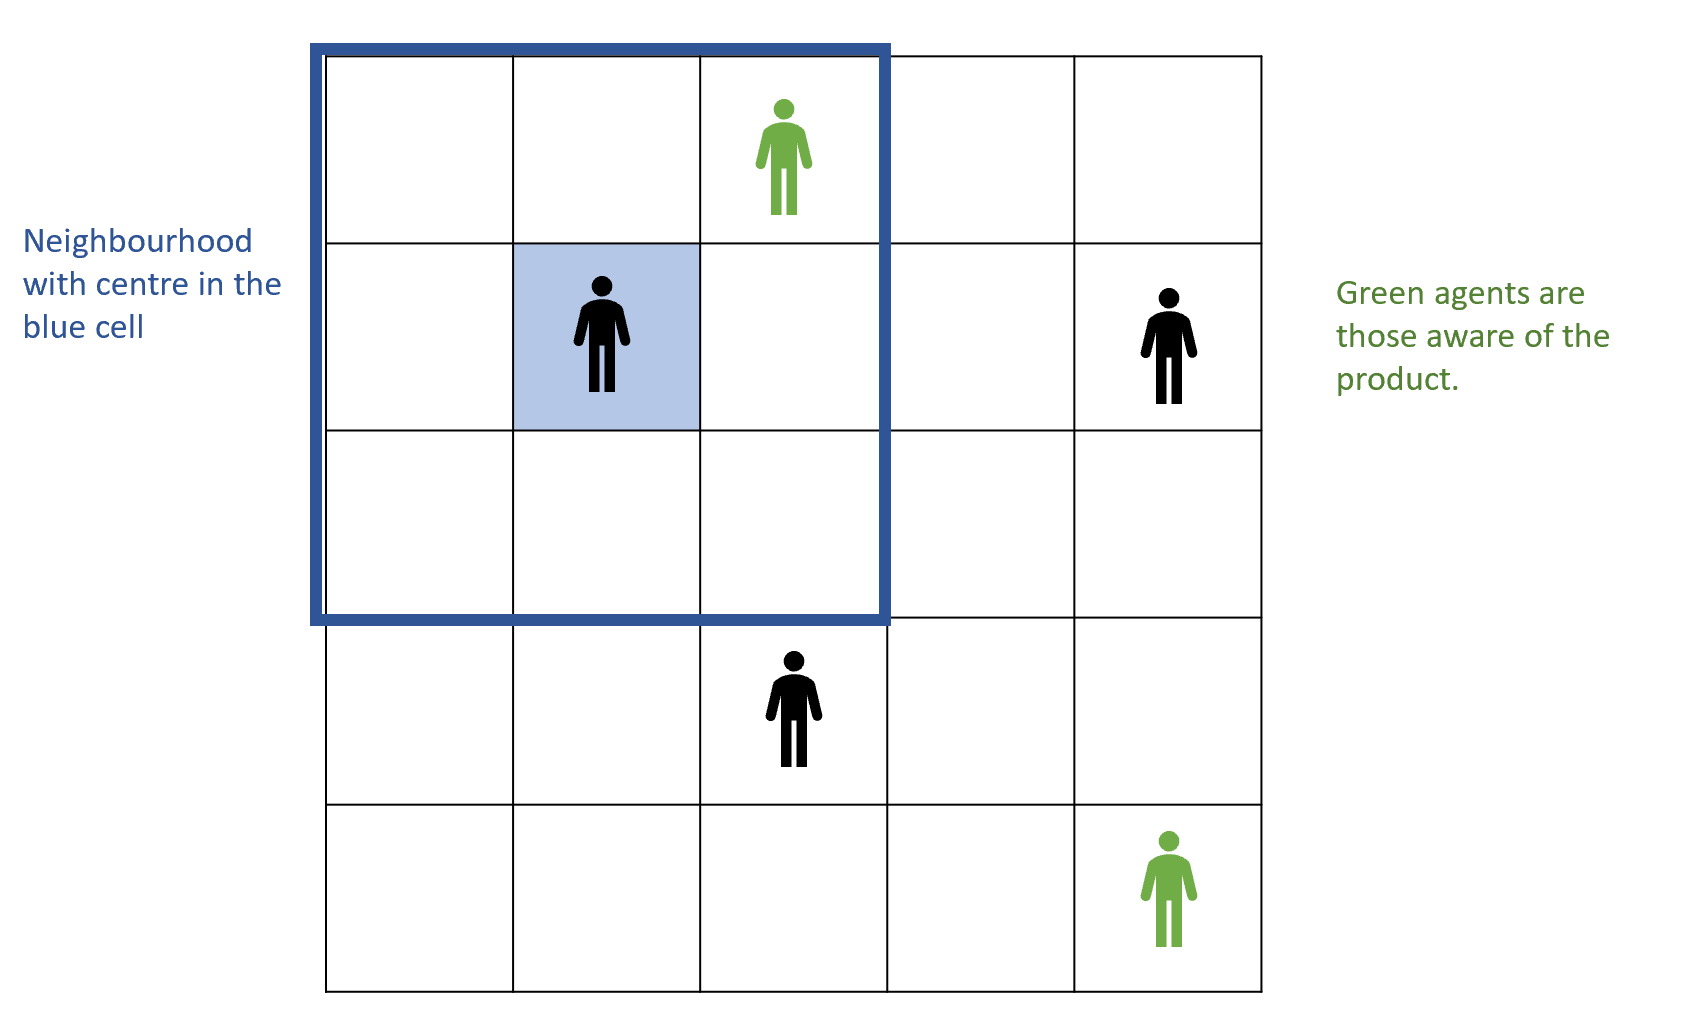

# Implementation with Python


Install **Mesa**, a “modular framework for building, analyzing and visualizing agent-based models” (official documentation [here](https://mesa.readthedocs.io/en/master/overview.html)). You can easily install it via pip.

In [1]:
!pip install mesa



In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
 #to collect features during the #simulation
from mesa.space import MultiGrid
 #to generate the environment

In [3]:
#for computation and visualization purpose
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
import random

Initialize the class of my Agent as follows:




In [4]:
class Agent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.knowledge = 0
        
    def spread_news(self):
        if self.knowledge == 0:
            return
        neighbors = self.model.grid.get_neighbors(self.pos,moore = True, include_center=True)
        neig_agents = [a for n in neighbors  for a in self.model.grid.get_cell_list_contents(n.pos)]
        for a in neig_agents:
            if random.random()<0.3:
                a.knowledge = 1
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        self.move()
        self.spread_news()

As anticipated,  agents are endowed with two main rules:

* **spread_news():** this function allows those agents which have a knowledge=1 to spread the information about the product. The neighbors get influenced with probability p=0.3.
* **move():** with this function, agents can move in one of the neighbor cells, according to the Moore definition of neighborhood.

Finally, the function step() allows the agent to perform both spread_news() and move() at each step of the simulation.

Now let’s define the model:

In [5]:
#let's define a function which is able to count, at each step, how many agents 
#are aware of the product. 

def compute_informed(model):
    return  sum([1 for a in model.schedule.agents if a.knowledge == 1])

#now let's define the model

class News_Model(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True 

        # Create agents
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            l = [1,2,3,4,5]
 #5 agents are aware of the product
            if i in l: #only agents with id in the list are aware of the product
                a.knowledge = 1

        self.datacollector = DataCollector(
            model_reporters = {"Tot informed": compute_informed},
            agent_reporters={"Knowledge": "knowledge"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Simulation and Results

Now run model with 100 agents, in a grid with height = width = 50.

In [6]:
'''Run the model '''
model = News_Model(100, 50, 50)
for i in range(100):
    model.step()

#let's inspect the results:
out = model.datacollector.get_agent_vars_dataframe().groupby('Step').sum()
out

,Knowledge
Step,
0,5
1,7
2,8
3,8
4,10
...,...
95,96
96,96
97,96


<AxesSubplot:xlabel='Step'>

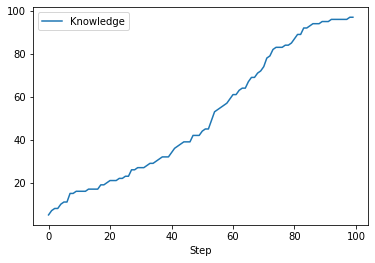

In [7]:
out.plot()


So after 100 steps, more than 80% of the initial population got influenced, starting only with 5 agents aware of the product.

This was a very naive model, yet it provides us with meaningful insight. In a more complex framework for the same scenario, one might be interested in inspecting if the position of the initial agents aware of the product is relevant in terms of the speed of diffusion. Plus, this scenario would be very well modeled with a network framework as underlying structure: we could inspect which are the most important nodes (aka agents) to target first, in order for the knowledge of the product to spread faster.